In [1]:
import numpy as np
import pandas as pd
import json
from pprint import pp
import tldextract
from scipy import stats

from retrieval_importance import split, learn_importance, encode_retrievals, encode_groups, grouped_weights, \
    most_important_groups, least_important_groups, retrievals_from_json, evaluate, evaluate_pruned, \
    tune_pruning_threshold, mode

np.random.seed(1311)

## Retrieval-Augmented Question Answering

We leverage **question answering on the [wikifact](https://github.com/google-research-datasets/wikifact) dataset with a retrieval-augmented LLM** as example use case. This dataset contains questions, which are extracted from Wikipedia pages using relation pairs. The answer to each question in this dataset can be found on Wikipedia.

For each relation in wikifact, we **created a retrieval corpus by querying [Microsoft Bing](https://www.microsoft.com/en-us/bing/apis/bing-web-search-api) and prompting [GPT-JT6B](https://huggingface.co/togethercomputer/GPT-JT-6B-v1)** based on a textual snippet for each retrieved website.

Let us take a look at the task of answering questions about the *place of birth* of persons:

In [22]:
application = 'question_answering'
task = 'wikifact__place_of_birth'

retrievals = retrievals_from_json(f'./applications/{application}/{task}.jsonl')

Each entry of our corpus contains a sample (the question to answer), together with correct answers, and the answers generated by our LLM based on the retrieved websites (as ranked by Bing). Here are the details of the first entry:

In [23]:
sample_to_inspect = retrievals[0]
pp(sample_to_inspect, width=100, compact=True)

{'question': 'Bill Belzer was born in',
 'correct_answers': ['Kansas City', 'Kansas City, MO', 'KCMO', 'KC', 'Kansas City, Missouri',
                     'K.C.', 'Kansas City', 'Kansas City'],
 'retrieved_answers': ['Kansas City, Missouri', 'United States', 'Kansas City, Missouri',
                       'Kansas City, Missouri', 'Kansas City', 'Kansas City, Kansas', 'Albia, IA',
                       'Iowa City', 'Bridgeport, Connecticut', '1884 in Cronenberg, a part of W',
                       'Isleton CA', 'United States', 'New York', 'New York', 'Kirksville',
                       'North Salem, Missouri', 'Albia, Iowa', 'New England, North Dakota',
                       'Centerville, IA', 'Meadville, Missouri. He served in the U',
                       'Bridgeport, Connecticut', 'Bridgeport, Connecticut', 'New York', 'New York',
                       'Bridgeport, Connecticut', 'New York', 'North Salem, Missouri', 'Albia',
                       'Bridgeport, Connecticut on Au

We assume that the **final prediction is made by majority vote over the answers from the top-k websites**, e.g., for k=10:

In [26]:
topk_answers = sample_to_inspect['retrieved_answers'][:10]
topk_sources = sample_to_inspect['retrieved_websites'][:10]
list(zip(topk_answers, topk_sources))

[('Kansas City, Missouri', 'en.everybodywiki.com'),
 ('United States', 'depthbio.com'),
 ('Kansas City, Missouri', 'prabook.com'),
 ('Kansas City, Missouri', 'www.liquisearch.com'),
 ('Kansas City', 'www.famedborn.com'),
 ('Kansas City, Kansas', 'alchetron.com'),
 ('Albia, IA', 'www.mtayrnews.com'),
 ('Iowa City', 'www.press-citizen.com'),
 ('Bridgeport, Connecticut', 'www.thefamouspeople.com'),
 ('1884 in Cronenberg, a part of W', 'heimwerk.co')]

For the first sample, this approach predicts the correct answer:

In [27]:
prediction = mode(topk_answers)
prediction

'Kansas City, Missouri'

However, there are obviously also cases where the final prediction is wrong, even though some of the individual answers were correct. For example, we accidentally predict the country Suriname as the birth place of Tyrone Spong, instead of the required city Paramaribo: 

In [28]:
sample_with_wrong_prediction = retrievals[2]
sample_with_wrong_prediction['question']

'Tyrone Spong was born in'

In [29]:
sample_with_wrong_prediction['correct_answers']

['Paramaribo']

In [30]:
topk_answers = sample_with_wrong_prediction['retrieved_answers'][:10]
topk_sources = sample_with_wrong_prediction['retrieved_websites'][:10]
list(zip(topk_answers, topk_sources))

[('Suriname', 'en.wikipedia.org'),
 ('Paramaribo', 'de.wikipedia.org'),
 ('Paramaribo', 'wikiborn.com'),
 ('Suriname', 'www.celebsages.com'),
 ('Suriname', 'www.celebsagewiki.com'),
 ('Suriname', 'www.famousdetails.com'),
 ('Suriname', 'www.famousbirthdays.com'),
 ('Suriname', 'networthandsalary.com'),
 ('Netherlands', 'box.live'),
 ('Suriname', 'www.liquisearch.com')]

In [31]:
prediction = mode(topk_answers)
prediction

'Suriname'

## Data-Centric Refinement of the Retrieval Corpus

These examples demonstrate that we could improve the predictive performance of our approach by carefully selecting which websites to "trust". Ideally, we would want to prune the predictions from data sources which we often expect to give unreliable answers. 

In a recent paper, we show how to evaluate the data importance of data points in such a retrieval corpus using the multilinear extension of the model's utility function. Based on learned weights for the data sources, we can enhance the performance of the underlying LLM by only pruning the retrieval corpus, without requiring further training:

_Xiaozhong Lyu, Stefan Grafberger, Samantha Biegel, Shaopeng Wei, Meng Cao, Sebastian Schelter, Ce Zhang: Improving Retrieval-Augmented Large Language Models with Data-Centric Refinement_, TODO: add arxiv link


In the following, we demonstrate in detail how to achieve this.

First, we define the **utility function** that we aim to optimize for our task:

In [39]:
def utility(retrieved, prediction):
    if prediction in retrieved["correct_answers"]:
        return 1.0
    else:
        return 0.0

Next, we define how to **group the data sources** in the corpus, in this example, we group the websites returned from Bing by domain. We aim to **learn the data importance per group**.

In [40]:
def group(retrieved_from):    
    url_parts = tldextract.extract(retrieved_from)
    return f'{url_parts.domain}.{url_parts.suffix}'    

We split our corpus into equally sized validation and test set. Note that we do not retrain or fine-tune the underlying LLM, , so there is no training data required for our approach

In [41]:
validation, test = split(retrievals, 0.5)

Now, we **learn importance weights for the domains in the corpus**, check TODO pointer to paper for details on the algorithm.

In [34]:
encoded_retrievals, mapping = encode_retrievals(validation, "retrieved_websites", "retrieved_answers", utility)
grouping, group_mapping = encode_groups(mapping, group)

k = 10

weights = learn_importance(encoded_retrievals, k=k, learning_rate=10, num_steps=100, n_jobs=-1, grouping=grouping)
domain_weights = grouped_weights(weights, grouping, group_mapping)

We can inspect the 10 most important data sources in our corpus:

In [43]:
most_important_groups(domain_weights, 10)

[('alchetron.com', 1.0),
 ('biogossipy.com', 1.0),
 ('biographies.net', 1.0),
 ('bornglorious.com', 1.0),
 ('buzzlearn.com', 1.0),
 ('celebsagewiki.com', 1.0),
 ('depthbio.com', 1.0),
 ('discogs.com', 1.0),
 ('explained.today', 1.0),
 ('famedborn.com', 1.0)]

And analogously, the 10 least important data sources:

In [44]:
least_important_groups(domain_weights, 10)

[('ancestry.com', 0.0),
 ('ancientfaces.com', 0.0),
 ('britannica.com', 0.0),
 ('celebsages.com', 0.0),
 ('famousbirthdays.com', 0.0),
 ('famousdetails.com', 0.0),
 ('mutualart.com', 0.0),
 ('myheritage.com', 0.0),
 ('prabook.com', 0.0),
 ('thefamouspeople.com', 0.0)]

## Determining a pruning threshold on the validation set

Now that we have the learned weights for the data sources, we need to decide how to prune the corpus. We aim to remove all data sources with a weight below a given threshold. We tune this threshold on the validation set, by testing the impact of different thresholds (and different percentages of pruned data sources) on the utility of our predictions.

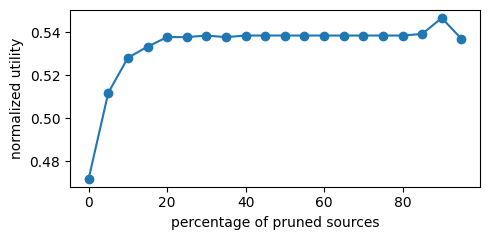

Found best (normalized) utility of 0.54667 on validation set with threshold 0.50968, pruning 90 percent of domains.


In [45]:
import matplotlib.pyplot as plt

percentile_range = range(0, 100, 5)

tuning_result = tune_pruning_threshold(validation, domain_weights, percentile_range, 
                                       utility, group, k, normalize=True)

plt.plot(percentile_range, tuning_result.achieved_utilities, marker='o')     
plt.ylabel('normalized utility')
plt.xlabel('percentage of pruned sources')
plt.gcf().set_size_inches(5, 2.5)
plt.tight_layout()
plt.show()
        
print(f'Found best (normalized) utility of {tuning_result.best_utility:.5f} on validation set ' +
      f'with threshold {tuning_result.best_threshold:.5f}, ' + 
      f'pruning {tuning_result.best_percentile} percent of domains.')          

## Final evaluation on unseen test set

Finally, we evaluate how much the data-centric pruning improves the accuracy of our predictions on the unseen test set. We first compute the **accuracy with the original retrieval corpus** without pruning:    

In [46]:
evaluate(test, utility, k, normalize=True)

0.48

Next, we compute the **accuracy on the test set after pruning the retrieval corpus** based on the threshold found on the validation set. We find that the accuracy improves by more than 6%!

In [48]:
evaluate_pruned(test, utility, group, k, tuning_result.best_threshold, domain_weights, normalize=True)

0.5474074074074075